# MEG and EEG Analysis with the MNE Software

Author : Alexandre Gramfort <alexandre.gramfort@inria.fr>

Powered by the [MNE package](http://martinos.org/mne/dev/index.html)

License : BSD 3 clause

First, load the mne package:

In [1]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [2]:
mne.set_log_level('WARNING')

Filter warnings and import matplotlib

In [3]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['font.size'] = 16

import warnings  # Hide all warnings here
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Access raw data

MNE gives simple access to [public datasets](http://martinos.org/mne/manual/datasets_index.html)

In [4]:
from mne.datasets import sample
data_path = sample.data_path()  # downloaded automatically (approx. 2GB)
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
print(raw_fname)  # the path to the file

/Users/alex/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif


Now let's read data from file:

In [5]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
print(raw)

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.1 MB, data loaded>


## Filtering

Band pass the data between 1Hz and 40Hz (based on `scipy.signal`)

In [6]:
raw.filter(1., 40., n_jobs=1)

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.1 MB, data loaded>

Metadata are stored in `raw.info` attribute (a `dict` with a nice `__repr__`)

In [7]:
raw.info

<Info | 24 non-empty fields
    acq_pars : str | 13886 items
    bads : list | MEG 2443, EEG 053
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (GRAD: 204, MAG: 102, STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 49 items
    dev_head_t : Transform | 3 items
    dig : list | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 1 items
    experimenter : str | 3 items
    file_id : dict | 4 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 376
    proc_history : list | 0 items
    proj_id : ndarray | 1 items
    proj_name : str | 4 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off
    sfreq : float | 600.614990234375 Hz
    acq_stim : NoneType
    ctf_head_t : NoneTy

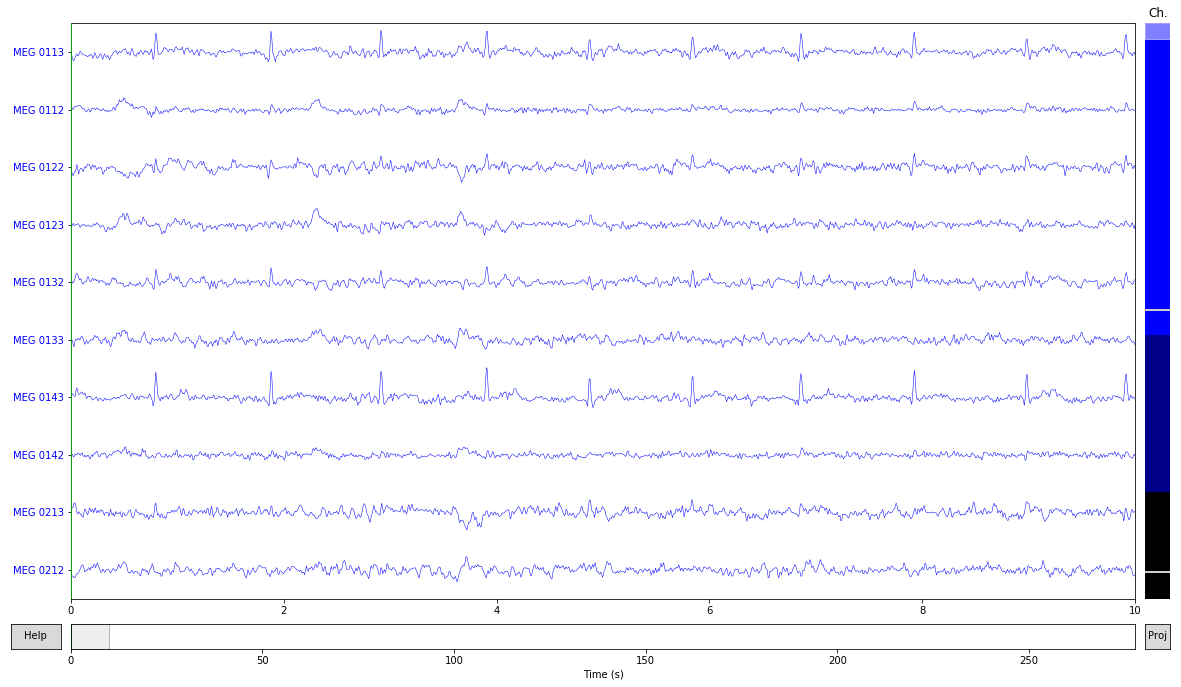

In [8]:
# %matplotlib notebook
fig = raw.plot(n_channels=10)

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['font.size'] = 16

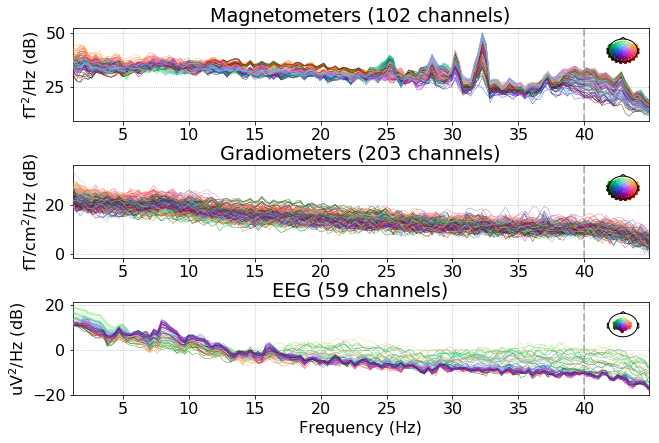

In [10]:
raw.plot_psd(fmin=1., fmax=45., tmax=60., average=False);

## Epochs and Events

Each presentation of a stimulus corresponds to an **epoch**.

An epoch is a segment of data around the presence of an **event**.

Let's extract events from the trigger/stimulation channel:

In [11]:
events = mne.find_events(raw, verbose=True)
print(events[:5])  # just a numpy array

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


Look at the design in a graphical way:

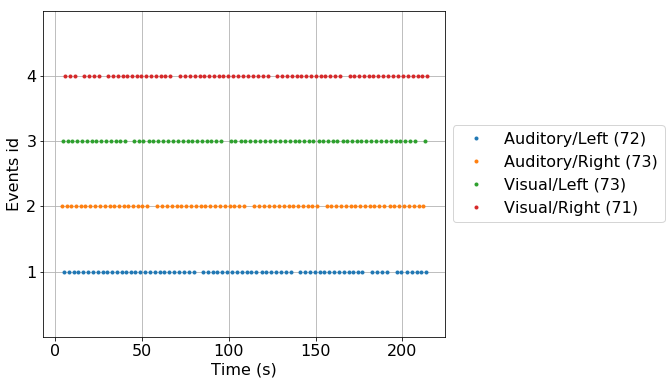

In [12]:
event_id = {"Auditory/Left": 1, "Auditory/Right": 2, "Visual/Left": 3, "Visual/Right": 4}
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id);

## From raw to epochs

In [13]:
event_id = {"Auditory/Left": 1, "Auditory/Right": 2, "Visual/Left": 3, "Visual/Right": 4}
tmin, tmax = -0.2, 0.5  # start and end of an epoch in sec.

# Set up indices of channels to include in analysis
picks = mne.pick_types(raw.info, meg=True, eeg=True, stim=True, eog=True,
                       exclude='bads')

# Read epochs
decim = 2  # decimate to make the example faster to run
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=None, preload=True,
                    reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6), decim=decim)

print(epochs)

<Epochs  |   236 events (all good), -0.199795 - 0.499488 sec, baseline off, ~145.7 MB, data loaded,
 'Auditory/Left': 55
 'Auditory/Right': 59
 'Visual/Left': 66
 'Visual/Right': 56>


### Let's open the box using plain numpy code

In [14]:
import numpy as np
data = epochs.get_data()
print(type(data))
print(data.shape)  # n_epochs, n_channels, n_times

<class 'numpy.ndarray'>
(236, 374, 211)


### Let's compute evoked responses

In [15]:
epochs.average()

<Evoked  |  '0.23 * Auditory/Left + 0.25 * Auditory/Right + 0.28 * Visual/Left + 0.24 * Visual/Right' (average, N=236), [-0.1998, 0.49949] sec, 364 ch, ~4.2 MB>

In [16]:
epochs['Left'].average()  # keep left stimuli

<Evoked  |  '0.45 * Auditory/Left + 0.55 * Visual/Left' (average, N=121), [-0.1998, 0.49949] sec, 364 ch, ~4.2 MB>

In [17]:
evoked = epochs['Auditory'].average()

### Let's plot the evoked responses

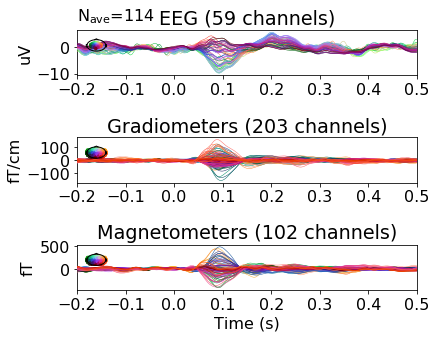

In [18]:
evoked.plot(spatial_colors=True);

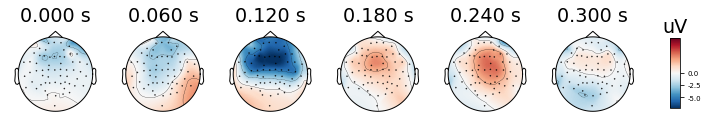

In [19]:
evoked.plot_topomap(ch_type='eeg', times=np.linspace(0., 0.3, 6));

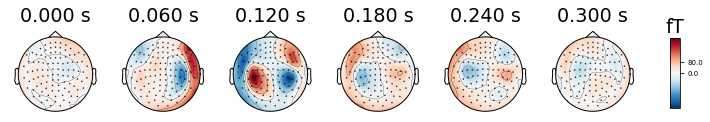

In [20]:
evoked.plot_topomap(ch_type='mag', times=np.linspace(0., 0.3, 6));

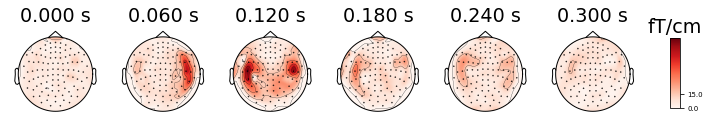

In [21]:
evoked.plot_topomap(ch_type='grad', times=np.linspace(0., 0.3, 6));

### Plot both jointly

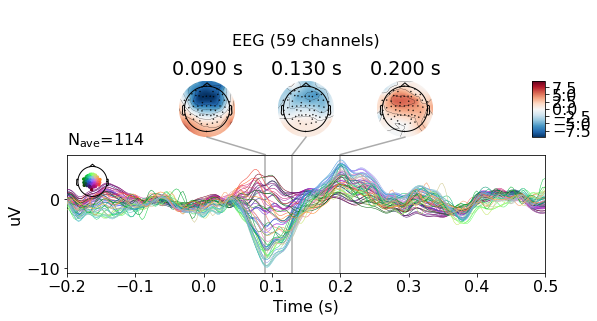

In [22]:
evoked.copy().pick_types(meg=False, eeg=True).plot_joint(times=[0.090, 0.130, 0.200]);

### Plot interactively with ipywidgets

In [23]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(time=(evoked.times[0], evoked.times[-1], 0.01),
          continuous_update=False)
def plot_topo(time):
    evoked.plot_topomap(ch_type='eeg', times=[time], size=3., vmin=-5., vmax=5.)

interactive(children=(FloatSlider(value=0.14020478684161217, description='time', max=0.49948803289596966, min=…

### Independant Component Analysis (ICA) to find latent sources in the data

We'll use the [PICARD ICA](https://pierreablin.github.io/picard/) Algorithm [(Ablin et al. IEEE Trans. Sig. Pro. 2017)](https://arxiv.org/abs/1706.08171)

In [24]:
from mne.preprocessing import ICA
ica = ICA(n_components=0.95, method='picard', random_state=0).fit(epochs, decim=4)

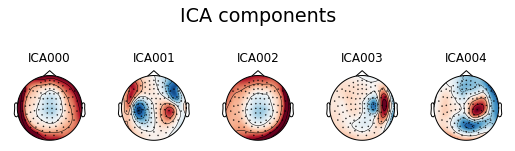

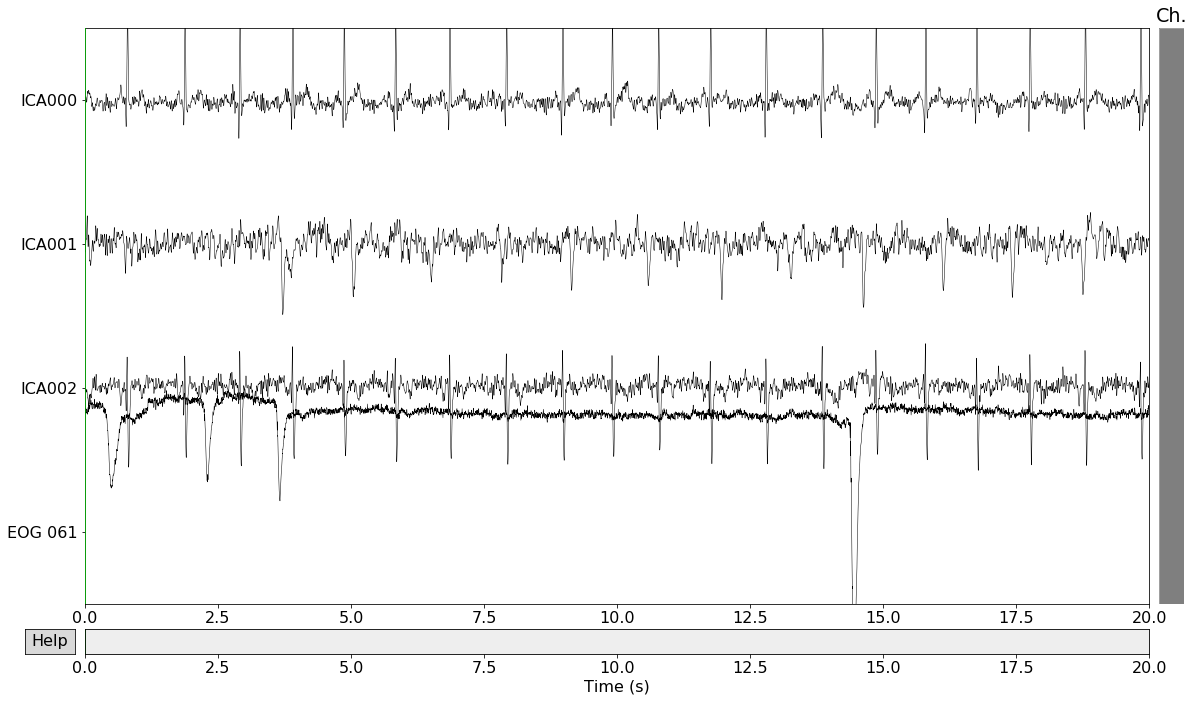

In [25]:
ica.plot_components(picks=range(5));
ica.plot_sources(raw.copy().crop(0, 20), picks=range(3));

## Where does it come from in the brain?

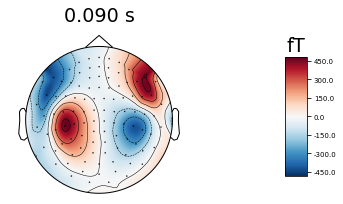

In [26]:
evoked.plot_topomap(times=[0.09], size=2);

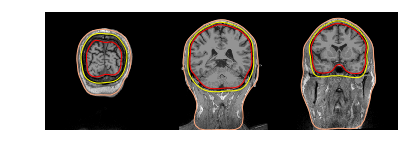

In [27]:
# Let's look the anatomy of the subject
subjects_dir = data_path + '/subjects'
mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir, slices=[50, 100, 150]);

In [28]:
# Let's look how the head fits in the system (coregistration)
fname_bem = data_path + '/subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif'
fname_trans = data_path + ('/MEG/sample/sample_audvis_raw-trans.fif')

`mne.viz.plot_alignment(evoked.info,
                       trans=fname_trans, subject='sample',
                       subjects_dir=subjects_dir);`

<img src='./sample_plot_trans.png' width='300px'>

## We now try to explain the data with 1 dipole

Use `scipy.optimize` to find the optimal location (least square sense)

In [29]:
cov = mne.compute_covariance(epochs)  # estimate noise covariance
from joblib import Memory  # load cached result

mem = Memory(cachedir='./', verbose=0)

evoked_dip = evoked.copy().crop(0.095, 0.095)
evoked_dip.set_eeg_reference(projection=True)  # set common average reference
dipole, _ = mem.cache(mne.fit_dipole)(
                evoked_dip,
                cov, fname_bem, fname_trans)
print(dipole)

<Dipole  |  n_times : 1, tmin : 0.097, tmax : 0.097>


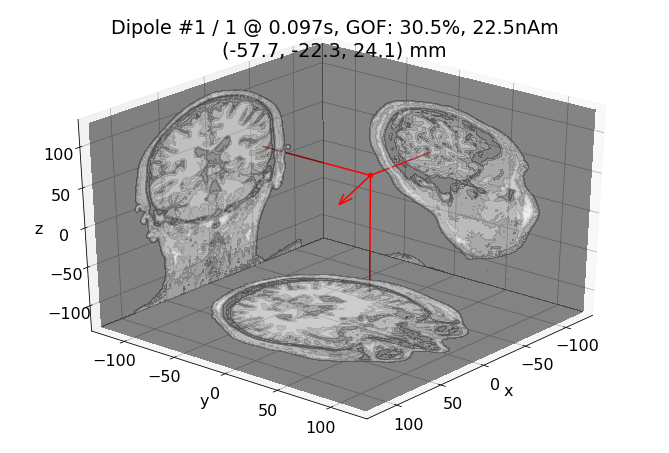

In [30]:
dipole.plot_locations(trans=fname_trans, subject='sample',
                      subjects_dir=subjects_dir);

## MNE + scikit-learn to classify brain responses

Let's import some [scikit-learn](http://scikit-learn.org) building blocks and the rest from `
mne.decoding` module:

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from mne.decoding import SlidingEstimator, cross_val_multiscore

In [32]:
picks = mne.pick_types(epochs.info, meg=True, ref_meg=False, stim=False)
X = epochs.get_data()[:, picks]  # MEG signals: n_epochs, n_channels, n_times
y = (epochs.events[:, 2] - 1) // 2  # target: visual or auditory

clf = make_pipeline(StandardScaler(), LogisticRegression())

X_2d = X.reshape(len(X), -1)
scores = cross_val_score(clf, X_2d, y, cv=5, n_jobs=1, scoring='accuracy')

# Mean scores across cross-validation splits
print("Cross-validation (Accuracy) score : %s" % np.mean(scores))

Cross-validation (Accuracy) score : 1.0


Now let's do it time point by time point using MNE

In [33]:
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits for each time instant
scores = np.mean(scores, axis=0)
print(scores.shape)
print(X.shape)

(211,)
(236, 305, 211)


Then plot CV score over time.

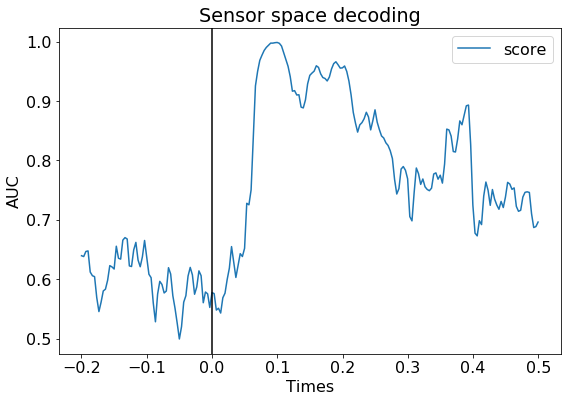

In [34]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()